# Stage 3 — Participation Features

## Purpose

This stage constructs **participation uncertainty features** — empirical estimators of whether a player will play, and how volatile their minutes have been. These features capture availability risk, which is distinct from performance quality.

The key insight: **you can't score points if you don't play**. Before modeling expected points, we must first model the probability of participation.

Features are computed from a rolling 5-gameweek window of prior appearances. The temporal contract is strictly enforced: features for gameweek $t$ use only data from gameweeks $\leq t-1$.

This stage does NOT use FPL's "chance of playing" flags. Those are noisy and updated irregularly. Instead, we compute empirical rates from actual historical minutes.

## Inputs & Outputs

| Item | Description |
|------|-------------|
| **Input** | `gameweeks` table from `storage/fpl_2025_26.sqlite` |
| **Output** | `storage/datasets/features_participation.csv` |
| **Produced by** | `dugout.pipeline.features_participation` |
| **Status** | 🔒 Frozen, read-only |

### Features Produced

| Feature | Description |
|---------|-------------|
| `p_play_hat` | Empirical play rate (minutes > 0) over last 5 GWs |
| `p60_hat` | Empirical 60+ minute rate over last 5 GWs |
| `mins_std_5` | Standard deviation of minutes over last 5 GWs |
| `mins_below_60_rate_5` | Rate of sub-60 minute appearances over last 5 GWs |

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load frozen artifacts
features = pd.read_csv("../storage/datasets/features_participation.csv")
targets = pd.read_csv("../storage/datasets/targets.csv")

print(f"Rows: {len(features):,}")
print(f"Players: {features['player_id'].nunique()}")
print(f"Gameweeks: {features['gw'].min()} to {features['gw'].max()}")
features.head(23)

Rows: 16,559
Players: 799
Gameweeks: 1 to 22


,player_id,gw,p_play_hat,p60_hat,mins_std_5,mins_below_60_rate_5
0,1,1,NaN,NaN,NaN,NaN
1,1,2,1.0,1.0,NaN,0.0
2,1,3,1.0,1.0,0.0,0.0
3,1,4,1.0,1.0,0.0,0.0
4,1,5,1.0,1.0,0.0,0.0
5,1,6,1.0,1.0,0.0,0.0
6,1,7,1.0,1.0,0.0,0.0
7,1,8,1.0,1.0,0.0,0.0
8,1,9,1.0,1.0,0.0,0.0
9,1,10,1.0,1.0,0.0,0.0


## Structural Sanity Checks

In [4]:
# Row alignment with targets
print(f"Features rows: {len(features):,}")
print(f"Targets rows:  {len(targets):,}")
print(f"Match: {len(features) == len(targets)}")

# Missingness
print("\nMissingness by column:")
miss = features.isna().mean().sort_values(ascending=False)
for col, rate in miss.items():
    print(f"  {col}: {rate:.1%}")

Features rows: 16,559
Targets rows:  16,559
Match: True

Missingness by column:
  mins_std_5: 9.6%
  p_play_hat: 4.8%
  p60_hat: 4.8%
  mins_below_60_rate_5: 4.8%
  player_id: 0.0%
  gw: 0.0%


In [5]:
# Why are ~10% of rows missing?
# -> First gameweek per player has no prior history

# Check: GW 1 should be all NaN
gw1 = features[features["gw"] == 1]
print(f"GW 1 rows: {len(gw1)}")
print(f"GW 1 p_play_hat NaN rate: {gw1['p_play_hat'].isna().mean():.1%}")

# Check: GW 2+ should have high coverage
gw2_plus = features[features["gw"] >= 2]
print(f"\nGW 2+ rows: {len(gw2_plus)}")
print(f"GW 2+ p_play_hat NaN rate: {gw2_plus['p_play_hat'].isna().mean():.1%}")

GW 1 rows: 690
GW 1 p_play_hat NaN rate: 100.0%

GW 2+ rows: 15869
GW 2+ p_play_hat NaN rate: 0.7%


## Distribution of Participation Features

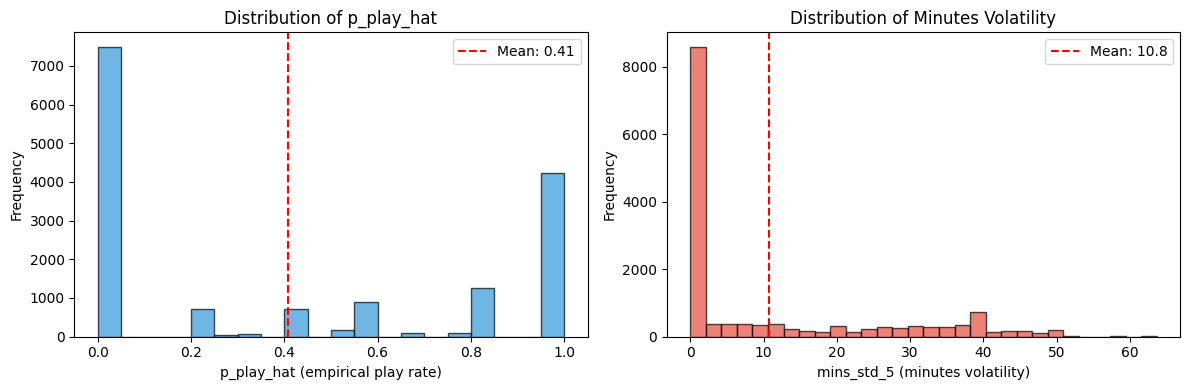

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# p_play_hat distribution
valid = features["p_play_hat"].dropna()
axes[0].hist(valid, bins=20, edgecolor="black", alpha=0.7, color="#3498db")
axes[0].axvline(valid.mean(), color="red", linestyle="--", label=f"Mean: {valid.mean():.2f}")
axes[0].set_xlabel("p_play_hat (empirical play rate)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of p_play_hat")
axes[0].legend()

# mins_std_5 distribution
valid_std = features["mins_std_5"].dropna()
axes[1].hist(valid_std, bins=30, edgecolor="black", alpha=0.7, color="#e74c3c")
axes[1].axvline(valid_std.mean(), color="red", linestyle="--", label=f"Mean: {valid_std.mean():.1f}")
axes[1].set_xlabel("mins_std_5 (minutes volatility)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Minutes Volatility")
axes[1].legend()

plt.tight_layout()
plt.show()

## Interpretation

### Bimodal p_play_hat

The distribution of `p_play_hat` is bimodal:
- **Spike near 0**: Bench players, youth players, injured players who rarely feature
- **Spike near 1**: Regular starters who play most weeks

The middle range (0.3-0.7) represents rotation-risk players — the hardest to predict.

### Why Minutes Volatility Matters

Two players might both have `p_play_hat = 0.6`, but:
- Player A: Plays 60 mins or 0 mins (high volatility, rotation victim)
- Player B: Plays 55-60 mins consistently (low volatility, reliable sub)

`mins_std_5` captures this distinction. High volatility indicates rotation risk even when a player frequently appears.

### Why Use Empirical Rates Instead of FPL Flags?

FPL provides "chance of playing" percentages (75%, 50%, 25%), but these are:
- Updated manually by FPL staff
- Often stale or inaccurate
- Not available historically for backtesting

Empirical rates computed from actual minutes are:
- Always available
- Consistent across seasons
- Backtestable

### Why Participation Is Separated

Participation and performance are **conditionally independent concerns**:
- A world-class striker who's injured scores 0 points
- A mediocre midfielder who plays every week scores more than an injured star

By modeling participation separately, we can later combine: $E[\text{points}] = P(\text{play}) \times E[\text{points} | \text{play}]$

## What This Stage Enables

With participation features constructed, the pipeline can now:

1. **Train participation models** (`p_play`, `p60`) that predict availability
2. **Separate availability risk from performance quality** in downstream decisions
3. **Identify rotation-risk players** via minutes volatility features

These features feed directly into Stage 5's belief models for `p_play` and `p60`.